# Training a Jet Tagging with **DNN**

---
In this notebook, we perform a Jet identification task using a multiclass classifier based on a
Dense Neural Network (DNN). The problem consists on identifying a given jet as a quark, a gluon, a W, a Z, or a top,
based on set of physics-motivated high-level features.

For details on the physics problem, see https://arxiv.org/pdf/1804.06913.pdf

For details on the dataset, see Notebook1

---

In [76]:
import os
import h5py
import glob
import numpy as np
import matplotlib.pyplot as plt

In [77]:
%matplotlib inline

# Preparation of the training and validation samples

---
In order to import the dataset, we now
- clone the dataset repository (to import the data in Colab)
- load the h5 files in the data/ repository
- extract the data we need: a target and jetImage

To type shell commands, we start the command line with !

In [78]:
target = np.array([])
features = np.array([])
# we cannot load all data on Colab. So we just take a few files
datafiles =    ['jetImage_7_100p_0_10000.h5']
datafiles.append('jetImage_7_100p_10000_20000.h5')
datafiles.append('jetImage_7_100p_30000_40000.h5')
datafiles.append('jetImage_7_100p_40000_50000.h5')

# if you are running locallt, you can use the full dataset doing
# for fileIN in glob.glob("tutorials/HiggsSchool/data/*h5"):
for fileIN in datafiles:
    print("Appending %s" %fileIN)
    f = h5py.File(fileIN)
    myFeatures = np.array(f.get("jets")[:,[12, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 48, 52]])
    mytarget = np.array(f.get('jets')[0:,-6:-1])
    features = np.concatenate([features, myFeatures], axis=0) if features.size else myFeatures
    target = np.concatenate([target, mytarget], axis=0) if target.size else mytarget
print(target.shape, features.shape)

Appending jetImage_7_100p_0_10000.h5
Appending jetImage_7_100p_10000_20000.h5
Appending jetImage_7_100p_30000_40000.h5
Appending jetImage_7_100p_40000_50000.h5
(40000, 5) (40000, 16)


In [79]:
print(target)
#transform target in a vector of [0,...5]
v_target = target.argmax(axis=1).reshape(target.shape[0],1)
print(v_target)

[[1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 ...
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]]
[[0]
 [2]
 [4]
 ...
 [1]
 [1]
 [2]]


The dataset consists of nfilesx10000 jets, each represented by 16 features

In [80]:
f = h5py.File('jetImage_7_100p_0_10000.h5')
featurenames = f.get('jetFeatureNames')
selectedFeatures = np.array([12, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 48, 52])
i = 0
j = 0
for feature in featurenames:
    if (j < selectedFeatures.shape[0] and i == selectedFeatures[j]) :
        print(feature)
        j+=1
    i+=1

b'j_zlogz'
b'j_c1_b0_mmdt'
b'j_c1_b1_mmdt'
b'j_c1_b2_mmdt'
b'j_c2_b1_mmdt'
b'j_c2_b2_mmdt'
b'j_d2_b1_mmdt'
b'j_d2_b2_mmdt'
b'j_d2_a1_b1_mmdt'
b'j_d2_a1_b2_mmdt'
b'j_m2_b1_mmdt'
b'j_m2_b2_mmdt'
b'j_n2_b1_mmdt'
b'j_n2_b2_mmdt'
b'j_mass_mmdt'
b'j_multiplicity'




---

We now shuffle the data, splitting them into a training and a validation dataset with 2:1 ratio

In [81]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(features, target, test_size=0.33)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(26800, 16) (13200, 16) (26800, 5) (13200, 5)


# DNN model building

In [82]:
# keras imports
from keras.models import Model
from keras.layers import Dense, Input, Dropout, Flatten
from keras.utils import plot_model
from keras import backend as K
from keras import metrics
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN

In [83]:
input_shape = X_train.shape[1]
dropoutRate = 0.1
print(input_shape)

16


In [84]:
####
inputArray = Input(shape=(input_shape,))
#
x = Dense(50, activation='relu')(inputArray)
x = Dropout(dropoutRate)(x)
#
x = Dense(50, activation='relu')(x)
x = Dropout(dropoutRate)(x)
#
x = Dense(20, activation='relu')(x)
x = Dropout(dropoutRate)(x)
#
x = Dense(5, activation='relu')(x)
#
output = Dense(5, activation='softmax')(x)
####
model = Model(inputs=inputArray, outputs=output)

In [85]:
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 50)             │           850 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 20)             │         1,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 5)              │           105 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 5)              │            30 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,555 (17.79 KB)

 Trainable params: 4,555 (17.79 KB)

 Non-trainable params: 0 (0.00 B)

We now train the model

In [86]:
batch_size = 128
n_epochs = 40

In [87]:
# train
history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size, verbose = 2,
                validation_data=(X_val, y_val),
                callbacks = [
                EarlyStopping(monitor='val_loss', patience=10, verbose=1),
                TerminateOnNaN()])

Epoch 1/40
210/210 - 5s - 26ms/step - loss: 1.7347 - val_loss: 1.6096
Epoch 2/40
210/210 - 0s - 2ms/step - loss: 1.6111 - val_loss: 1.6097
Epoch 3/40
210/210 - 0s - 2ms/step - loss: 1.6112 - val_loss: 1.6097
Epoch 4/40
210/210 - 0s - 2ms/step - loss: 1.6099 - val_loss: 1.6096
Epoch 5/40
210/210 - 0s - 2ms/step - loss: 1.6077 - val_loss: 1.6096
Epoch 6/40
210/210 - 0s - 2ms/step - loss: 1.6029 - val_loss: 1.5542
Epoch 7/40
210/210 - 0s - 2ms/step - loss: 1.5264 - val_loss: 1.4645
Epoch 8/40
210/210 - 0s - 2ms/step - loss: 1.4684 - val_loss: 1.4359
Epoch 9/40
210/210 - 0s - 2ms/step - loss: 1.4397 - val_loss: 1.4200
Epoch 10/40
210/210 - 0s - 2ms/step - loss: 1.4258 - val_loss: 1.4127
Epoch 11/40
210/210 - 0s - 2ms/step - loss: 1.4137 - val_loss: 1.3826
Epoch 12/40
210/210 - 0s - 2ms/step - loss: 1.3429 - val_loss: 1.2634
Epoch 13/40
210/210 - 0s - 2ms/step - loss: 1.2495 - val_loss: 1.1660
Epoch 14/40
210/210 - 0s - 2ms/step - loss: 1.1733 - val_loss: 1.1144
Epoch 15/40
210/210 - 0s - 2

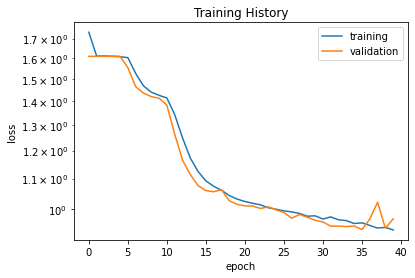

In [88]:
# plot training history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.yscale('log')
plt.title('Training History')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

To save on disk the best model and training results:

model_json = model.to_json()

with open("tutorials/HiggsSchool/models/jetTagger_DNN.json", "w") as json_file:

    json_file.write(model_json)
    
model.save_weights("tutorials/HiggsSchool/models/jetTagger_DNN.h5")

# Building the ROC Curves

In [89]:
labels = ['gluon', 'quark', 'W', 'Z', 'top']

413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


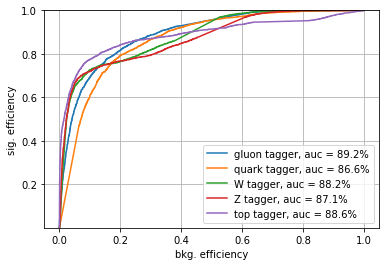

In [90]:
import pandas as pd
from sklearn.metrics import roc_curve, auc
predict_val = model.predict(X_val)
df = pd.DataFrame()
fpr = {}
tpr = {}
auc1 = {}

plt.figure()
for i, label in enumerate(labels):
        df[label] = y_val[:,i]
        df[label + '_pred'] = predict_val[:,i]

        fpr[label], tpr[label], threshold = roc_curve(df[label],df[label+'_pred'])

        auc1[label] = auc(fpr[label], tpr[label])

        plt.plot(fpr[label],tpr[label],label='%s tagger, auc = %.1f%%'%(label,auc1[label]*100.))
#plt.semilogy()
plt.xlabel("bkg. efficiency")
plt.ylabel("sig. efficiency")
plt.ylim(0.000001,1)
plt.grid(True)
plt.legend(loc='lower right')
plt.show()

In [108]:
from sklearn.metrics import confusion_matrix
#transform target in a vector of [0,...5]
y_val_vec = y_val.argmax(axis=1).reshape(y_val.shape[0],1)
#get from prob predictions to 0,1 values - use 0.5 as threashold
y_pred = (predict_val >= 0.5).astype(int)
y_pred_vec = y_pred.argmax(axis=1).reshape(y_pred.shape[0],1)
#print(y_pred_vec, y_val_vec)
#make confusion matrix normalizing on the columns (the total text events)
cf_matrix = confusion_matrix(y_val_vec,y_pred_vec, normalize='pred')


[[2]
 [4]
 [3]
 ...
 [1]
 [0]
 [0]] [[2]
 [4]
 [3]
 ...
 [1]
 [0]
 [0]]


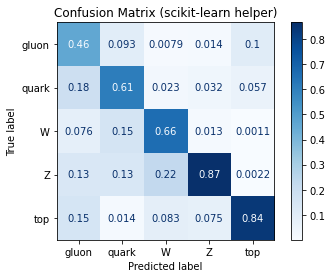

In [109]:
#plot the confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(cf_matrix, display_labels=labels)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix (scikit-learn helper)")
plt.show()

0.996